Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Is your problem regression or classification?
- [ ] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [ ] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?
    - Regression: Will you use mean absolute error, root mean squared error, R^2, or other regression metrics?
- [ ] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

If you haven't found a dataset yet, do that today. [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2) and choose your dataset.

Some students worry, ***what if my model isn't “good”?*** Then, [produce a detailed tribute to your wrongness. That is science!](https://twitter.com/nathanwpyle/status/1176860147223867393)

In [1]:
import pandas as pd

npi_data = pd.read_csv('./data.csv')
npi_data


,score,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,...,Q34,Q35,Q36,Q37,Q38,Q39,Q40,elapse,gender,age
0,18,2,2,2,2,1,2,1,2,2,...,1,1,2,2,2,1,2,211,1,50
1,6,2,2,2,1,2,2,1,2,1,...,2,1,2,2,2,2,1,149,1,40
2,27,1,2,2,1,2,1,2,1,2,...,1,2,1,1,2,1,2,168,1,28
3,29,1,1,2,2,2,1,2,1,1,...,1,2,1,2,2,1,1,230,1,37
4,6,1,2,1,1,1,2,1,2,1,...,2,1,2,2,2,0,1,389,1,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11238,1,2,2,2,1,1,2,1,2,1,...,2,1,2,2,2,2,1,243,1,24
11239,10,2,2,1,1,1,2,1,1,1,...,2,1,2,1,2,2,1,197,1,39
11240,6,1,2,2,1,1,2,1,2,1,...,2,1,2,2,2,2,1,447,2,33
11241,12,2,2,1,1,1,1,1,1,1,...,1,2,2,2,2,2,1,167,1,24


In [2]:
npi_data.describe()

,score,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,...,Q34,Q35,Q36,Q37,Q38,Q39,Q40,elapse,gender,age
count,11243.000000,11243.000000,11243.000000,11243.000000,11243.000000,11243.000000,11243.000000,11243.000000,11243.000000,11243.000000,...,11243.000000,11243.000000,11243.000000,11243.000000,11243.000000,11243.000000,11243.000000,1.124300e+04,11243.000000,11243.000000
mean,13.299653,1.385751,1.784844,1.827804,1.174242,1.422307,1.628391,1.302944,1.412612,1.456106,...,1.667882,1.257582,1.807614,1.688695,1.845860,1.606955,1.414925,1.195542e+05,1.429956,34.014231
std,8.508833,0.489890,0.415898,0.382250,0.386075,0.498074,0.486375,0.463982,0.496285,0.505537,...,0.477931,0.449954,0.400239,0.471613,0.370342,0.495859,0.498831,1.262668e+07,0.504348,15.015611
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000e+00,0.000000,0.000000
25%,7.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.040000e+02,1.000000,23.000000
50%,12.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,...,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.570000e+02,1.000000,30.000000
75%,18.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.410000e+02,2.000000,43.000000
max,40.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.338845e+09,3.000000,509.000000


In [3]:
npi_data.shape

(11243, 44)

In [4]:
# look at gender value counts for whole dataset

npi_data['gender'].value_counts()

1    6425
2    4766
3      40
0      12
Name: gender, dtype: int64

In [5]:
# look at age value counts for whole dataset

npi_data['age'].value_counts()

22     459
20     452
21     451
19     423
23     414
      ... 
509      1
6        1
190      1
366      1
100      1
Name: age, Length: 83, dtype: int64

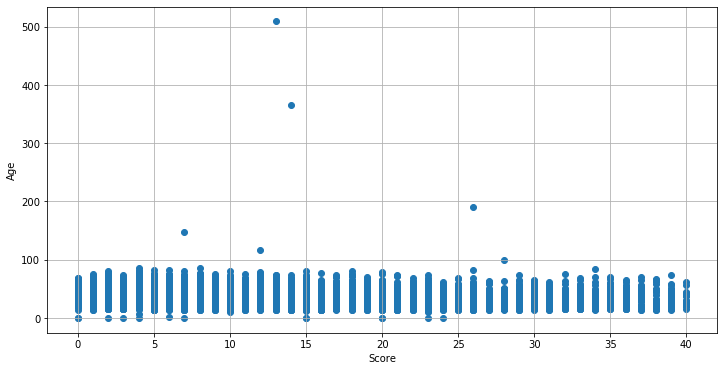

In [6]:
import matplotlib.pyplot as plt

# indentify outliers for age by using scatter plot 

fig, ax = plt.subplots(figsize=(12,6))
ax.grid()


ax.scatter(npi_data['score'], npi_data['age'])
ax.set_xlabel('Score')
ax.set_ylabel('Age')
plt.show()

In [7]:
# set age range for 15-100 years old for dataset 

index = npi_data[(npi_data['age'] >= 100)|(npi_data['age'] <= 15)].index
npi_data.drop(index, inplace=True)
npi_data['age'].describe()

count    11021.000000
mean        34.305780
std         13.657376
min         16.000000
25%         23.000000
50%         31.000000
75%         44.000000
max         86.000000
Name: age, dtype: float64

In [8]:
# clean gender column
# omitt useless gender from dataset '0'

index2 = npi_data[(npi_data['gender'] == 0)].index
npi_data.drop(index2, inplace=True)
npi_data['gender'].describe()

count    11009.000000
mean         1.429921
std          0.501287
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          3.000000
Name: gender, dtype: float64

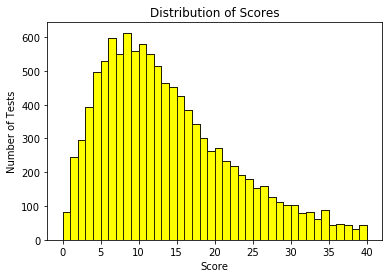

In [9]:
import seaborn as sns

# matplotlib histogram for distribution of scores
# historgram formatting

plt.hist(npi_data['score'], color = 'yellow', edgecolor = 'black',
         bins = 40)

sns.distplot(npi_data['score'], hist=True, kde=False, 
             bins=40, color = 'yellow',
             hist_kws={'edgecolor':'black'})

# add labels and title to histogram

plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Number of Tests')

plt.show()

In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(npi_data, test_size=0.3,
                              stratify = npi_data['gender'], random_state = 42)

train.shape, test.shape

((7706, 44), (3303, 44))

In [11]:
test, val = train_test_split(test, test_size=0.5,
                              stratify = test['gender'], random_state = 42)
train.shape, test.shape, val.shape

((7706, 44), (1651, 44), (1652, 44))

In [12]:
target = 'gender'
X_test = test.drop(columns=target)
y_test = test[target]
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]

In [13]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    ce.ordinal.OrdinalEncoder(),
    DecisionTreeClassifier()
)
pipeline.fit(X_train, y_train)
print(f'Val score (acc): {pipeline.score(X_val, y_val)}')

Val score (acc): 0.5647699757869249


In [14]:
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(
    ce.ordinal.OrdinalEncoder(),
    RandomForestClassifier()
)
pipeline.fit(X_train, y_train)
print(f'Val score (acc): {pipeline.score(X_val, y_val)}')

Val score (acc): 0.6325665859564165


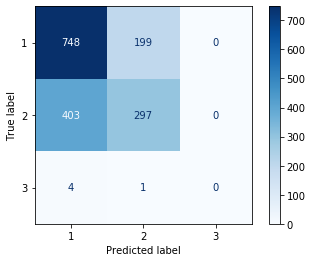

In [15]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipeline, X_val, y_val, 
                      xticks_rotation='horizontal', 
                      values_format='.0f',
                      cmap='Blues');

In [77]:
y_pred = pipeline.predict(X_val)

In [79]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_pred, y_val)

0.6193908524323941

In [80]:
from sklearn.metrics import average_precision_score
average_precision_score(y_pred, y_val)

0.6804300859932527

In [81]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_pred, y_val)

C:\Users\ryanh\Anaconda2\envs\unit2\lib\site-packages\sklearn\metrics\_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


0.6206533250258398